# Baseline Model with XGBoost

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
import joblib



In [21]:
load_forecasts_df = pd.read_hdf(r'C:\Users\Linds\Repos\East_River\data\training\east_river_processed_dataset-v4.h5')

In [22]:
# derive sine/cosine from existing day_of_week_num
load_forecasts_df['dow_sin'] = np.sin(2 * np.pi * load_forecasts_df['day_of_week_num'] / 7)
load_forecasts_df['dow_cos'] = np.cos(2 * np.pi * load_forecasts_df['day_of_week_num'] / 7)

In [23]:
# Print all column names
print(load_forecasts_df.columns.to_list())

['location', 'local_time', 'temperature', 'wind_speed', 'wind_degree', 'humidity', 'visibility', 'pressure', 'cloudcover', 'windgust', 'uv_index', 'snowfall', 'snow_depth', 'relative_humidity_2m', 'global_tilted_irradiance', 'diffuse_radiation', 'pressure_msl', 'surface_pressure', 'blended_precip', 'OnLine_Load_MW', 'Load_Control_MW', 'Control_Threshold_MW', 'is_weekend', 'is_holiday', 'hour', 'minute', 'day', 'month', 'year', 'hour_sin', 'hour_cos', 'day_of_week_num', 'load_lag_3_rolling_std_3', 'load_lag_3_rolling_std_6', 'load_lag_3_rolling_std_12', 'load_diff_1', 'load_diff_24hr', 'load_lag_3_rolling_std_24hrs', 'last_control_time', 'time_since_control_minutes', 'peak_diff', 'time_since_peak_minutes', 'precip_sum_6hrs', 'day_of_year_sin', 'day_of_year_cos', 'prev_day_peak', 'prev_day_avg', 'prev_week_peak', 'temp_humidity_interaction', 'wind_precip_interaction', 'was_controlled', 'load_lag_1_rolling_mean_6hrs', 'load_lag_1_rolling_std_6hrs', 'load_lag_1_rolling_std_24hrs', 'wind_di

In [24]:
print("Shape of DataFrame:", load_forecasts_df.shape)

Shape of DataFrame: (12101700, 122)


In [25]:
load_forecasts_df['local_time'].head()

6304   2020-12-31 18:00:00-06:00
6595   2020-12-31 18:30:00-06:00
6730   2020-12-31 19:00:00-06:00
6797   2020-12-31 19:30:00-06:00
6971   2020-12-31 20:00:00-06:00
Name: local_time, dtype: datetime64[ns, America/Chicago]

In [26]:
load_forecasts_df.describe()

,temperature,wind_speed,wind_degree,humidity,visibility,pressure,cloudcover,windgust,uv_index,snowfall,...,prev_day_avg,prev_week_peak,temp_humidity_interaction,wind_precip_interaction,was_controlled,load_lag_1_rolling_mean_6hrs,load_lag_1_rolling_std_6hrs,load_lag_1_rolling_std_24hrs,dow_sin,dow_cos
count,1.210170e+07,1.210170e+07,1.210170e+07,1.210170e+07,1.210170e+07,1.210170e+07,1.210170e+07,1.210170e+07,1.210170e+07,1.210170e+07,...,1.210170e+07,1.210170e+07,1.210170e+07,1.210170e+07,1.210170e+07,1.210170e+07,1.210170e+07,1.210170e+07,1.210170e+07,1.210170e+07
mean,4.842397e+01,1.008251e+01,1.944103e+02,6.795401e+01,5.491789e+00,2.997935e+01,4.266795e+01,1.629390e+01,2.330231e+00,8.307405e-03,...,4.991313e+02,6.311486e+02,3.027775e+03,2.937011e-02,4.274623e-01,4.990997e+02,2.295910e+01,4.506398e+01,1.689643e-03,6.592649e-04
std,2.349676e+01,4.872334e+00,9.750524e+01,2.196270e+01,1.419590e+00,2.564435e-01,3.711841e+01,6.972459e+00,2.014494e+00,7.832107e-02,...,7.066652e+01,8.647355e+01,1.562102e+03,2.700833e-01,4.947103e-01,8.168873e+01,1.382795e+01,2.023214e+01,7.072996e-01,7.069117e-01
min,-3.100000e+01,0.000000e+00,0.000000e+00,6.000000e+00,0.000000e+00,2.888000e+01,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,...,3.460387e+02,4.465000e+02,-3.100000e+03,0.000000e+00,0.000000e+00,2.704875e+02,0.000000e+00,0.000000e+00,-9.749279e-01,-9.009689e-01
25%,3.000000e+01,6.500000e+00,1.270000e+02,5.100000e+01,6.000000e+00,2.981500e+01,7.000000e+00,1.100000e+01,1.000000e+00,0.000000e+00,...,4.467160e+02,5.673500e+02,1.972000e+03,0.000000e+00,0.000000e+00,4.373772e+02,1.220486e+01,3.030567e+01,-7.818315e-01,-9.009689e-01
50%,5.000000e+01,9.000000e+00,1.800000e+02,7.100000e+01,6.000000e+00,2.997000e+01,3.150000e+01,1.550000e+01,1.000000e+00,0.000000e+00,...,4.958140e+02,6.430100e+02,2.848000e+03,0.000000e+00,0.000000e+00,4.933308e+02,2.038268e+01,3.877093e+01,0.000000e+00,-2.225209e-01
75%,6.700000e+01,1.300000e+01,2.900000e+02,8.800000e+01,6.000000e+00,3.012000e+01,8.000000e+01,2.100000e+01,3.000000e+00,0.000000e+00,...,5.423281e+02,6.924000e+02,4.087000e+03,0.000000e+00,1.000000e+00,5.517669e+02,3.120818e+01,5.547021e+01,7.818315e-01,6.234898e-01
max,1.130000e+02,3.700000e+01,3.600000e+02,1.000000e+02,6.000000e+00,3.098000e+01,1.000000e+02,5.900000e+01,1.000000e+01,3.080000e+00,...,8.278835e+02,9.077240e+02,8.316000e+03,3.000000e+01,1.000000e+00,8.112962e+02,1.101171e+02,1.283815e+02,9.749279e-01,1.000000e+00


In [27]:
load_forecasts_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12101700 entries, 6304 to 12166803
Columns: 122 entries, location to dow_cos
dtypes: bool(66), datetime64[ns, America/Chicago](2), float64(44), int32(9), object(1)
memory usage: 5.5+ GB


C:\Users\Linds\AppData\Local\Temp\ipykernel_51868\3721528552.py:9: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


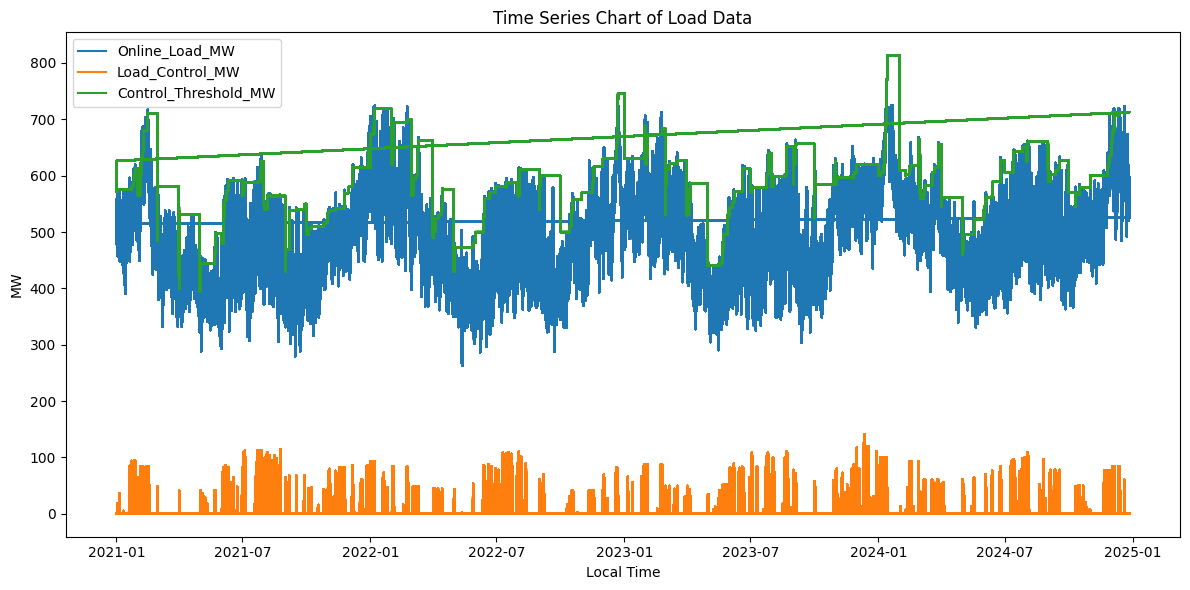

In [9]:
plt.figure(figsize=(12,6))
plt.plot(load_forecasts_df['local_time'], load_forecasts_df['OnLine_Load_MW'], label='Online_Load_MW')
plt.plot(load_forecasts_df['local_time'], load_forecasts_df['Load_Control_MW'], label='Load_Control_MW')
plt.plot(load_forecasts_df['local_time'], load_forecasts_df['Control_Threshold_MW'], label='Control_Threshold_MW')
plt.xlabel('Local Time')
plt.ylabel('MW')
plt.title('Time Series Chart of Load Data')
plt.legend()
plt.tight_layout()
plt.show()

From the overlaid time‐series plot of OnLine_Load_MW, Load_Control_MW and Control_Threshold_MW we observe:

- A strong daily (diurnal) cycle in actual demand (OnLine_Load_MW), with clear peaks in the afternoon/evening and troughs overnight.  
- The Control_Threshold_MW line shifts up and down over time (reflecting changing system or market limits) but generally sits just above the uncontrolled load.  
- Whenever actual demand tries to exceed the threshold, the curtailed load (Load_Control_MW) exactly tracks the threshold—showing active curtailment.  
- Periods with no curtailment have all three lines coinciding, while gaps between OnLine_Load_MW and Load_Control_MW highlight the amount of load shed.

Insight: demand follows a regular rhythm, thresholds adapt dynamically, and curtailment kicks in precisely when demand would otherwise breach those limits.

Top 10 columns by % missing:
location                                              0.0
weather_descriptions_Moderate or heavy rain shower    0.0
weather_descriptions_Mist                             0.0
weather_descriptions_Light snow showers               0.0
weather_descriptions_Light snow                       0.0
weather_descriptions_Light sleet showers              0.0
weather_descriptions_Light sleet                      0.0
weather_descriptions_Light showers of ice pellets     0.0
weather_descriptions_Light rain shower                0.0
weather_descriptions_Light rain                       0.0
dtype: float64


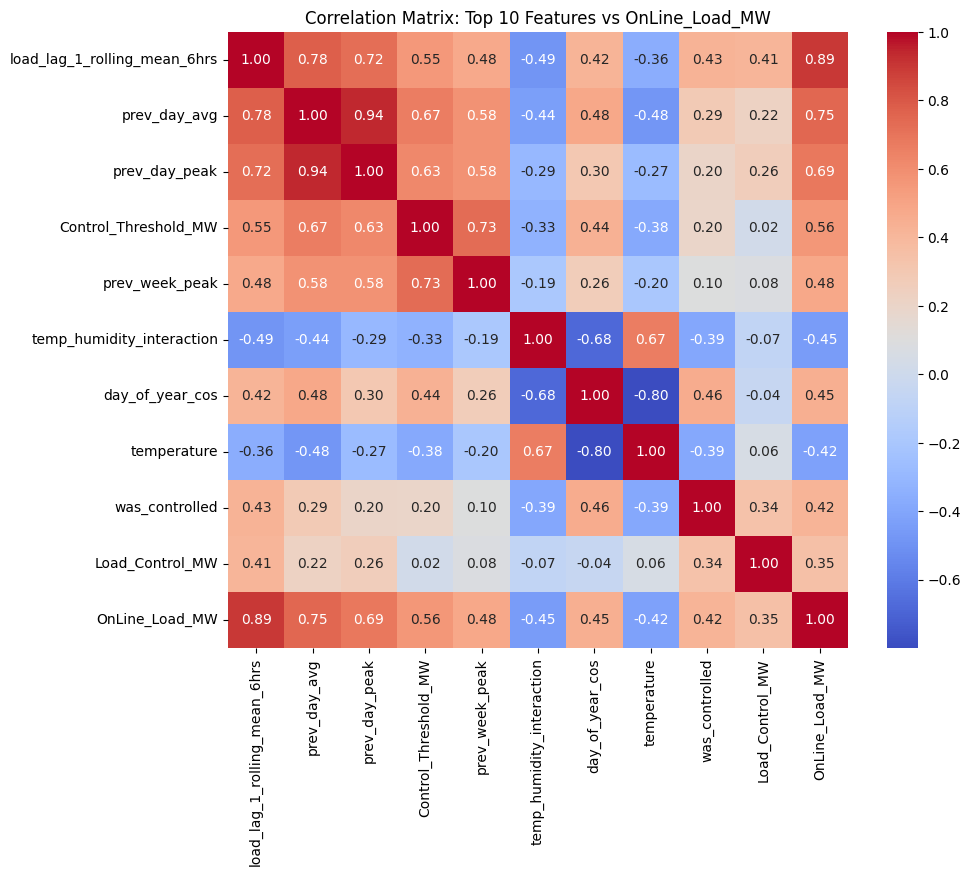

In [10]:
# 1) Missing‐value summary
null_pct = load_forecasts_df.isnull().mean().sort_values(ascending=False) * 100
print("Top 10 columns by % missing:")
print(null_pct.head(10))

# 2) Find top 10 features most correlated with the target
corr = load_forecasts_df.drop(columns=['location']).corr()
top_feats = corr['OnLine_Load_MW'].abs().sort_values(ascending=False).drop('OnLine_Load_MW').head(10).index

# 3) Plot heatmap of correlations among those top features + target
plt.figure(figsize=(10, 8))
sns.heatmap(load_forecasts_df[top_feats.tolist() + ['OnLine_Load_MW']].corr(),
            annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix: Top 10 Features vs OnLine_Load_MW")
plt.show()

The missing‑value summary (`null_pct`) shows 0 % missing in every column, so no imputation is needed.

The top 10 features most strongly linearly associated with OnLine_Load_MW (from `top_feats`) are:
- load_lag_1_rolling_mean_6hrs  
- prev_day_avg  
- prev_day_peak  
- Control_Threshold_MW  
- prev_week_peak  
- temp_humidity_interaction  
- day_of_year_cos  
- temperature  
- was_controlled  
- Load_Control_MW  


In [28]:
print(load_forecasts_df.columns.to_list())

['location', 'local_time', 'temperature', 'wind_speed', 'wind_degree', 'humidity', 'visibility', 'pressure', 'cloudcover', 'windgust', 'uv_index', 'snowfall', 'snow_depth', 'relative_humidity_2m', 'global_tilted_irradiance', 'diffuse_radiation', 'pressure_msl', 'surface_pressure', 'blended_precip', 'OnLine_Load_MW', 'Load_Control_MW', 'Control_Threshold_MW', 'is_weekend', 'is_holiday', 'hour', 'minute', 'day', 'month', 'year', 'hour_sin', 'hour_cos', 'day_of_week_num', 'load_lag_3_rolling_std_3', 'load_lag_3_rolling_std_6', 'load_lag_3_rolling_std_12', 'load_diff_1', 'load_diff_24hr', 'load_lag_3_rolling_std_24hrs', 'last_control_time', 'time_since_control_minutes', 'peak_diff', 'time_since_peak_minutes', 'precip_sum_6hrs', 'day_of_year_sin', 'day_of_year_cos', 'prev_day_peak', 'prev_day_avg', 'prev_week_peak', 'temp_humidity_interaction', 'wind_precip_interaction', 'was_controlled', 'load_lag_1_rolling_mean_6hrs', 'load_lag_1_rolling_std_6hrs', 'load_lag_1_rolling_std_24hrs', 'wind_di

In [29]:
# Check the current DataFrame shape
print(load_forecasts_df.shape)

(12101700, 122)


In [30]:
# convert all True/False columns to 0/1
bool_cols = load_forecasts_df.select_dtypes(include='bool').columns
load_forecasts_df[bool_cols] = load_forecasts_df[bool_cols].astype(int)

In [31]:
load_forecasts_df.head()

,location,local_time,temperature,wind_speed,wind_degree,humidity,visibility,pressure,cloudcover,windgust,...,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,weather_event_normal,weather_event_storm,dow_sin,dow_cos
6304,"Aberdeen, South Dakota",2020-12-31 18:00:00-06:00,19.0,6.0,184.0,91.0,6.0,30.120,16.0,14.0,...,0,0,0,0,0,0,1,0,0.433884,-0.900969
6595,"Aberdeen, South Dakota",2020-12-31 18:30:00-06:00,18.5,6.0,186.0,91.0,6.0,30.135,13.5,14.0,...,0,0,0,0,0,0,1,0,0.433884,-0.900969
6730,"Aberdeen, South Dakota",2020-12-31 19:00:00-06:00,18.0,6.0,188.0,91.0,6.0,30.150,11.0,14.0,...,0,0,0,0,0,0,1,0,0.433884,-0.900969
6797,"Aberdeen, South Dakota",2020-12-31 19:30:00-06:00,18.0,6.0,190.0,91.0,6.0,30.150,9.0,13.0,...,0,0,0,0,0,0,1,0,0.433884,-0.900969
6971,"Aberdeen, South Dakota",2020-12-31 20:00:00-06:00,18.0,6.0,192.0,91.0,6.0,30.150,7.0,12.0,...,0,0,0,0,0,0,1,0,0.433884,-0.900969


In [15]:
# convert any non‑numeric columns (e.g. bools, datetimes, objects) into integer codes
for col in load_forecasts_df.select_dtypes(exclude=[np.number]).columns:
    load_forecasts_df[col] = load_forecasts_df[col].astype('category').cat.codes

# verify none remain
print("still non‑numeric:", load_forecasts_df.select_dtypes(exclude=[np.number]).columns.tolist())

still non‑numeric: []


In [32]:
to_encode = (
    load_forecasts_df
    .select_dtypes(exclude=[np.number])
    .columns
    .difference(['location','local_time'])
)

for col in to_encode:
    load_forecasts_df[col] = load_forecasts_df[col].astype('category').cat.codes

print("still non‑numeric:", load_forecasts_df
      .select_dtypes(exclude=[np.number])
      .columns
      .tolist())

still non‑numeric: ['location', 'local_time']


In [35]:
# check for any missing or infinite values in the entire DataFrame
has_missing = load_forecasts_df.isnull().values.any()
# only numeric columns support infinite‐value detection
num_df = load_forecasts_df.select_dtypes(include=[np.number])
has_infinite = np.isinf(num_df.values).any()

print(f"Missing values present? {has_missing}")
print(f"Infinite values present? {has_infinite}")

Missing values present? False
Infinite values present? False


In [36]:
# check for constant columns
unique_counts = load_forecasts_df.nunique()
constant_cols = unique_counts[unique_counts <= 1].index.tolist()
if constant_cols:
    print("Constant columns detected:", constant_cols)
else:
    print("No constant columns detected.")

No constant columns detected.


In [37]:
# ensure chronological ordering before modeling
load_forecasts_df.sort_values('local_time', inplace=True)
load_forecasts_df.reset_index(drop=True, inplace=True)


In [40]:
load_forecasts_df.head(200)

,location,local_time,temperature,wind_speed,wind_degree,humidity,visibility,pressure,cloudcover,windgust,...,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,weather_event_normal,weather_event_storm,dow_sin,dow_cos
0,"Aberdeen, South Dakota",2020-12-31 18:00:00-06:00,19.0,6.0,184.0,91.0,6.0,30.120,16.0,14.0,...,0,0,0,0,0,0,1,0,0.433884,-0.900969
1,"Spain, South Dakota",2020-12-31 18:00:00-06:00,19.0,6.0,189.0,92.0,6.0,30.150,21.0,12.0,...,0,0,0,0,0,0,1,0,0.433884,-0.900969
2,"Colman, South Dakota",2020-12-31 18:00:00-06:00,18.0,8.0,160.0,93.0,6.0,30.180,25.0,15.0,...,0,0,0,0,0,0,1,0,0.433884,-0.900969
3,"Spencer, South Dakota",2020-12-31 18:00:00-06:00,19.0,8.0,161.0,92.0,6.0,30.180,12.0,16.0,...,0,0,0,0,0,0,1,0,0.433884,-0.900969
4,"Clear Lake, South Dakota",2020-12-31 18:00:00-06:00,18.0,5.0,187.0,94.0,3.0,30.180,31.0,10.0,...,0,0,0,0,0,0,1,0,0.433884,-0.900969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,"Minneota, Minnesota",2020-12-31 18:30:00-06:00,18.5,6.0,157.5,88.5,6.0,30.210,6.5,10.5,...,0,0,0,0,0,0,1,0,0.433884,-0.900969
196,"Howard, South Dakota",2020-12-31 18:30:00-06:00,19.0,6.5,133.0,92.0,6.0,30.135,15.0,12.0,...,0,0,0,0,0,0,1,0,0.433884,-0.900969
197,"Wahpeton, North Dakota",2020-12-31 18:30:00-06:00,18.0,8.0,148.0,92.0,6.0,30.195,24.0,16.0,...,0,0,0,0,0,0,1,0,0.433884,-0.900969
198,"Arco, Minnesota",2020-12-31 18:30:00-06:00,18.0,8.5,170.5,93.5,6.0,30.195,34.5,16.0,...,0,0,0,0,0,0,1,0,0.433884,-0.900969


In [41]:
# create shifted targets for 24, 48, and 72 h ahead
horizons = [24, 48, 72]
for H in horizons:
    load_forecasts_df[f'y_plus_{H}h'] = load_forecasts_df['OnLine_Load_MW'].shift(-H)

# drop trailing rows with missing targets
load_forecasts_df.dropna(subset=[f'y_plus_{H}h' for H in horizons], inplace=True)

In [42]:
load_forecasts_df.head()

,location,local_time,temperature,wind_speed,wind_degree,humidity,visibility,pressure,cloudcover,windgust,...,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,weather_event_normal,weather_event_storm,dow_sin,dow_cos,y_plus_24h,y_plus_48h,y_plus_72h
0,"Aberdeen, South Dakota",2020-12-31 18:00:00-06:00,19.0,6.0,184.0,91.0,6.0,30.12,16.0,14.0,...,0,0,0,1,0,0.433884,-0.900969,514.37,514.37,514.37
1,"Spain, South Dakota",2020-12-31 18:00:00-06:00,19.0,6.0,189.0,92.0,6.0,30.15,21.0,12.0,...,0,0,0,1,0,0.433884,-0.900969,514.37,514.37,514.37
2,"Colman, South Dakota",2020-12-31 18:00:00-06:00,18.0,8.0,160.0,93.0,6.0,30.18,25.0,15.0,...,0,0,0,1,0,0.433884,-0.900969,514.37,514.37,514.37
3,"Spencer, South Dakota",2020-12-31 18:00:00-06:00,19.0,8.0,161.0,92.0,6.0,30.18,12.0,16.0,...,0,0,0,1,0,0.433884,-0.900969,514.37,514.37,514.37
4,"Clear Lake, South Dakota",2020-12-31 18:00:00-06:00,18.0,5.0,187.0,94.0,3.0,30.18,31.0,10.0,...,0,0,0,1,0,0.433884,-0.900969,514.37,514.37,514.37


In [36]:
# create shifted targets for 24,48,72h horizons
horizons = [24, 48, 72]               # hours ahead to predict


# create new target columns
for H in horizons:
    load_forecasts_df[f'y_plus_{H}h'] = load_forecasts_df['OnLine_Load_MW'].shift(-H)

# drop rows at end that don’t have a full horizon
load_forecasts_df = load_forecasts_df.dropna(subset=[f'y_plus_{H}h' for H in horizons])

In [43]:
# save the final processed DataFrame to HDF5
load_forecasts_df.to_hdf('east_river_training-v1.h5', key='df', mode='w')

In [45]:
# drop non‐predictive or leakage columns:
# - 'local_time', 'last_control_time': date/time info not used directly as features
# - 'OnLine_Load_MW', 'Load_Control_MW', 'Control_Threshold_MW': these are current/controlled load values (either target or leakage)
# - y_plus_*h: the shifted targets for each horizon
cols_to_drop = [
    'local_time',
    'last_control_time',
    'OnLine_Load_MW',
    'Load_Control_MW',
    'Control_Threshold_MW'
] + [f'y_plus_{H}h' for H in horizons]

print("Columns to drop:", cols_to_drop)

Columns to drop: ['local_time', 'last_control_time', 'OnLine_Load_MW', 'Load_Control_MW', 'Control_Threshold_MW', 'y_plus_24h', 'y_plus_48h', 'y_plus_72h']


In [47]:
# define feature columns by excluding non-predictive/leakage columns
feature_cols = [c for c in load_forecasts_df.columns if c not in cols_to_drop]

In [49]:
#loop over horizons, fit and evaluate
results = []
for H in horizons:
    X = load_forecasts_df[feature_cols]
    y = load_forecasts_df[f'y_plus_{H}h']

    split = int(len(X) * 0.8)
    X_train, X_test = X.iloc[:split], X.iloc[split:]
    y_train, y_test = y.iloc[:split], y.iloc[split:]

    model = XGBRegressor(tree_method='hist', random_state=0)
    # drop the object column
    X_train = X_train.drop(columns="location")
    X_test  = X_test.drop(columns="location")
    
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    mae  = mean_absolute_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)

    results.append({'horizon_h': H, 'MAE': mae, 'RMSE': rmse})
    print(f"Horizon {H}h — MAE: {mae:.2f} MW, RMSE: {rmse:.2f} MW")

# 3) collect results
pd.DataFrame(results).set_index('horizon_h')

Horizon 24h — MAE: 9.54 MW, RMSE: 13.03 MW
Horizon 48h — MAE: 10.01 MW, RMSE: 13.59 MW
Horizon 72h — MAE: 10.36 MW, RMSE: 13.97 MW


,MAE,RMSE
horizon_h,,
24,9.544760,13.032488
48,10.007958,13.590096
72,10.359988,13.970080


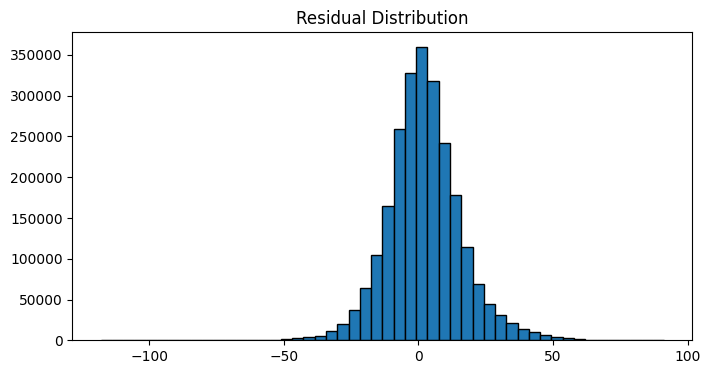

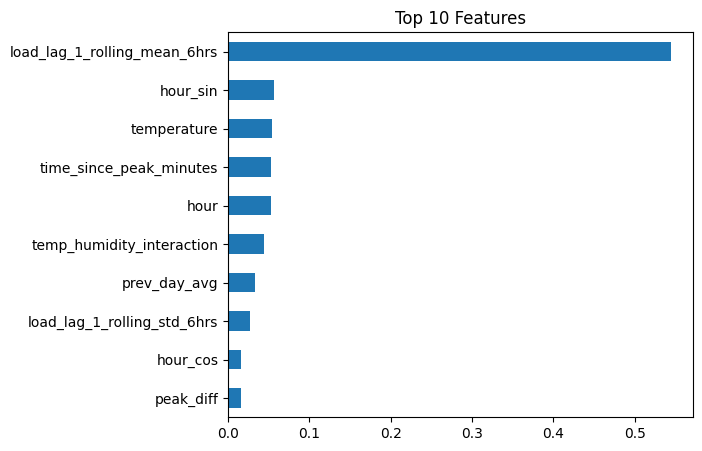

In [50]:
# residuals
resid = y_test.reset_index(drop=True) - y_pred
plt.figure(figsize=(8,4))
plt.hist(resid, bins=50, edgecolor='k')
plt.title("Residual Distribution"); plt.show()

# feature importance
imp = pd.Series(model.feature_importances_, index=X_train.columns)
plt.figure(figsize=(6,5))
imp.nlargest(10).sort_values().plot.barh(title="Top 10 Features")
plt.show()

The residual‐histogram shows how prediction errors (y_test – y_pred) are distributed. From it you can tell:

- Centering around zero:  means the model is largely unbiased (no systematic over‐ or under‐prediction).  
- “Bell‐shaped”/Gaussian‐like form: supports the idea that errors are roughly normally distributed, a good sign for many regression assumptions.  
- Spread (width) of the distribution: reflects the typical magnitude of errors (consistent with the RMSE/MAE you computed).  
- Tails/outliers: any pronounced heavy tails or skew would signal occasional large errors or systematic bias at higher/lower values.  

Overall, a well‐centered, symmetric bell‐shape indicates the XGBRegressor is making unbiased predictions with errors that behave like random noise.

Reducing MAE from 103 MW to around 9–10 MW (and RMSE from 126 MW to ~13–14 MW) is dramatic.  
That’s roughly a 90% drop in error, meaning  XGBoost model captures most of the signal that simple historical averages could not.

In [56]:
# Hyperparameter tuning with time‐series CV and evaluation 
param_grid = {
  'n_estimators': [100, 200, 300],
  'max_depth':    [3, 5, 7],
  'learning_rate':[0.01, 0.05, 0.1],
  'subsample':    [0.8, 1.0],
  'colsample_bytree':[0.8, 1.0]
}

search_results = []
tuned_metrics = []

# to mitigate MemoryError, only tune on a smaller time‐contiguous slice
max_tune_samples = 2_000_000
tune_data = load_forecasts_df.iloc[:max_tune_samples]

for H in horizons:
  # use the smaller slice for X and y during CV
  X = tune_data[feature_cols].drop(columns='location')
  y = tune_data[f'y_plus_{H}h']
  split = int(len(X) * 0.8)
  X_train, X_test = X.iloc[:split], X.iloc[split:]
  y_train, y_test = y.iloc[:split], y.iloc[split:]

  search = RandomizedSearchCV(
      estimator=XGBRegressor(tree_method='hist', random_state=0),
      param_distributions=param_grid,
      n_iter=10,
      cv=tscv,
      scoring='neg_mean_absolute_error',
      n_jobs=-1,
      random_state=0
  )
  search.fit(X_train, y_train)

  best_model = search.best_estimator_
  search_results.append({
      'horizon_h': H,
      'best_params': search.best_params_,
      'cv_MAE': -search.best_score_
  })

  # hold‐out evaluation
  y_pred = best_model.predict(X_test)
  mae  = mean_absolute_error(y_test, y_pred)
  rmse = root_mean_squared_error(y_test, y_pred)
  tuned_metrics.append({'horizon_h': H, 'MAE': mae, 'RMSE': rmse})

  # persist
  joblib.dump(best_model, f'xgb_tuned_{H}h.pkl')

# summarize
cv_results_df   = pd.DataFrame(search_results).set_index('horizon_h')
test_results_df = pd.DataFrame(tuned_metrics).set_index('horizon_h')

print("Time‐Series CV tuning results:")
print(cv_results_df)
print("\nHold‐out test metrics for tuned models:")
print(test_results_df)

Time‐Series CV tuning results:
                                                 best_params     cv_MAE
horizon_h                                                              
24         {'subsample': 1.0, 'n_estimators': 200, 'max_d...  25.166330
48         {'subsample': 1.0, 'n_estimators': 200, 'max_d...  25.107647
72         {'subsample': 1.0, 'n_estimators': 200, 'max_d...  25.954774

Hold‐out test metrics for tuned models:
                 MAE       RMSE
horizon_h                      
24         14.446855  18.581712
48         14.348266  18.458562
72         14.698485  18.822709


In [ ]:
# pick a  tuning slice
cv_sample_size = 6000000 
tune_sample = tune_data.iloc[:cv_sample_size]

# fewer splits and iterations
tscv_small = TimeSeriesSplit(n_splits=3)
n_iter_small = 5

tune_results = []
for H in horizons:
    Xs = tune_sample[feature_cols].drop(columns='location')
    ys = tune_sample[f'y_plus_{H}h']
    split = int(len(Xs) * 0.8)
    Xtr, Xte = Xs.iloc[:split], Xs.iloc[split:]
    ytr, yte = ys.iloc[:split], ys.iloc[split:]

    search = RandomizedSearchCV(
        estimator=XGBRegressor(tree_method='hist', random_state=0),
        param_distributions=param_grid,
        n_iter=n_iter_small,
        cv=tscv_small,
        scoring='neg_mean_absolute_error',
        n_jobs=1,            # reduce parallelism
        random_state=0,
        verbose=1
    )
    search.fit(Xtr, ytr)
    best = search.best_estimator_

    ypred = best.predict(Xte)
    tune_results.append({
        'horizon_h': H,
        'best_params': search.best_params_,
        'cv_MAE':      -search.best_score_,
        'MAE':          mean_absolute_error(yte, ypred),
        'RMSE':         root_mean_squared_error(yte, ypred)
    })

pd.DataFrame(tune_results).set_index('horizon_h')

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Fitting 3 folds for each of 5 candidates, totalling 15 fits


,best_params,cv_MAE,MAE,RMSE
horizon_h,,,,
24,"{'subsample': 1.0, 'n_estimators': 200, 'max_d...",32.337785,14.446855,18.581712
48,"{'subsample': 1.0, 'n_estimators': 200, 'max_d...",33.133338,14.348266,18.458562
72,"{'subsample': 1.0, 'n_estimators': 200, 'max_d...",33.874887,14.698485,18.822709


In [ ]:
# More stable TimeSeriesSplit on the 6 M tuning slice
tscv_stable = TimeSeriesSplit(n_splits=3, max_train_size=6_000_000)

print("Stable TimeSeriesSplit CV (MAE) on 2 M slice:")
for H in horizons:
    y = tune_data[f'y_plus_{H}h']
    scores = cross_val_score(
        XGBRegressor(tree_method='hist', random_state=0),
        X, y,
        cv=tscv_stable,
        scoring='neg_mean_absolute_error',
        n_jobs=-1
    )
    print(f"{H}h — MAE: {-scores.mean():.2f} ± {scores.std():.2f}")

Stable TimeSeriesSplit CV (MAE) on 2 M slice:
24h — MAE: 19.68 ± 4.94
48h — MAE: 21.59 ± 6.52
72h — MAE: 21.54 ± 6.33


In [62]:
from sklearn.model_selection import KFold, cross_val_score

# prepare feature matrix once
X = tune_data[feature_cols].drop(columns='location')

print("Compare Random K-Fold vs. TimeSeriesSplit CV (MAE):")
for H in horizons:
    y = tune_data[f'y_plus_{H}h']
    # Random K-Fold
    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    rand_scores = cross_val_score(
        XGBRegressor(tree_method='hist', random_state=0),
        X, y,
        cv=kf,
        scoring='neg_mean_absolute_error',
        n_jobs=-1
    )
    # TimeSeriesSplit
    ts_scores = cross_val_score(
        XGBRegressor(tree_method='hist', random_state=0),
        X, y,
        cv=tscv,
        scoring='neg_mean_absolute_error',
        n_jobs=-1
    )
    print(
        f"{H}h – RandomCV MAE: {-rand_scores.mean():.2f} ± {rand_scores.std():.2f}; "
        f"TimeSeriesSplit MAE: {-ts_scores.mean():.2f} ± {ts_scores.std():.2f}"
    )

Compare Random K-Fold vs. TimeSeriesSplit CV (MAE):
24h – RandomCV MAE: 4.05 ± 0.03; TimeSeriesSplit MAE: 25.05 ± 18.17
48h – RandomCV MAE: 4.53 ± 0.02; TimeSeriesSplit MAE: 27.50 ± 19.85
72h – RandomCV MAE: 4.89 ± 0.02; TimeSeriesSplit MAE: 28.78 ± 21.45
